In [1]:
from lib import to_rgb
%matplotlib inline
%load_ext autoreload

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from PIL import Image
from tqdm import tqdm

import torch
import torchvision
from torch.utils.data import Dataset
from torchvision import transforms
from torchvision.transforms import InterpolationMode
from torchvision.transforms import v2

import lib

## Load the data

In [2]:
train_features = pd.read_csv("data/train_features.csv", index_col="id")
test_features = pd.read_csv("data/test_features.csv", index_col="id")
train_labels = pd.read_csv("data/train_labels.csv", index_col="id")

In [3]:
train_features

,filepath,site
id,,
ZJ000000,train_features/ZJ000000.jpg,S0120
ZJ000001,train_features/ZJ000001.jpg,S0069
ZJ000002,train_features/ZJ000002.jpg,S0009
ZJ000003,train_features/ZJ000003.jpg,S0008
ZJ000004,train_features/ZJ000004.jpg,S0036
...,...,...
ZJ016483,train_features/ZJ016483.jpg,S0093
ZJ016484,train_features/ZJ016484.jpg,S0043
ZJ016485,train_features/ZJ016485.jpg,S0089


In [4]:
test_features

,filepath,site
id,,
ZJ016488,test_features/ZJ016488.jpg,S0082
ZJ016489,test_features/ZJ016489.jpg,S0040
ZJ016490,test_features/ZJ016490.jpg,S0040
ZJ016491,test_features/ZJ016491.jpg,S0041
ZJ016492,test_features/ZJ016492.jpg,S0040
...,...,...
ZJ020947,test_features/ZJ020947.jpg,S0086
ZJ020948,test_features/ZJ020948.jpg,S0152
ZJ020949,test_features/ZJ020949.jpg,S0162


In [5]:
train_labels.head()

,antelope_duiker,bird,blank,civet_genet,hog,leopard,monkey_prosimian,rodent
id,,,,,,,,
ZJ000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
ZJ000001,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
ZJ000002,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
ZJ000003,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
ZJ000004,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


### Make sure one-hot encoding is correct

In [6]:
assert train_labels[train_labels.sum(axis=1) != 1].shape[0] == 0

In [7]:
species_labels = sorted(train_labels.columns.unique())
species_labels

['antelope_duiker',
 'bird',
 'blank',
 'civet_genet',
 'hog',
 'leopard',
 'monkey_prosimian',
 'rodent']

## Explore the data

Now let's see what some of the actual images look like. The code below iterates through a list of species and selects a single random image from each species to display, along with its image ID and label. You can try changing the `random_state` variable to display a new set of images.

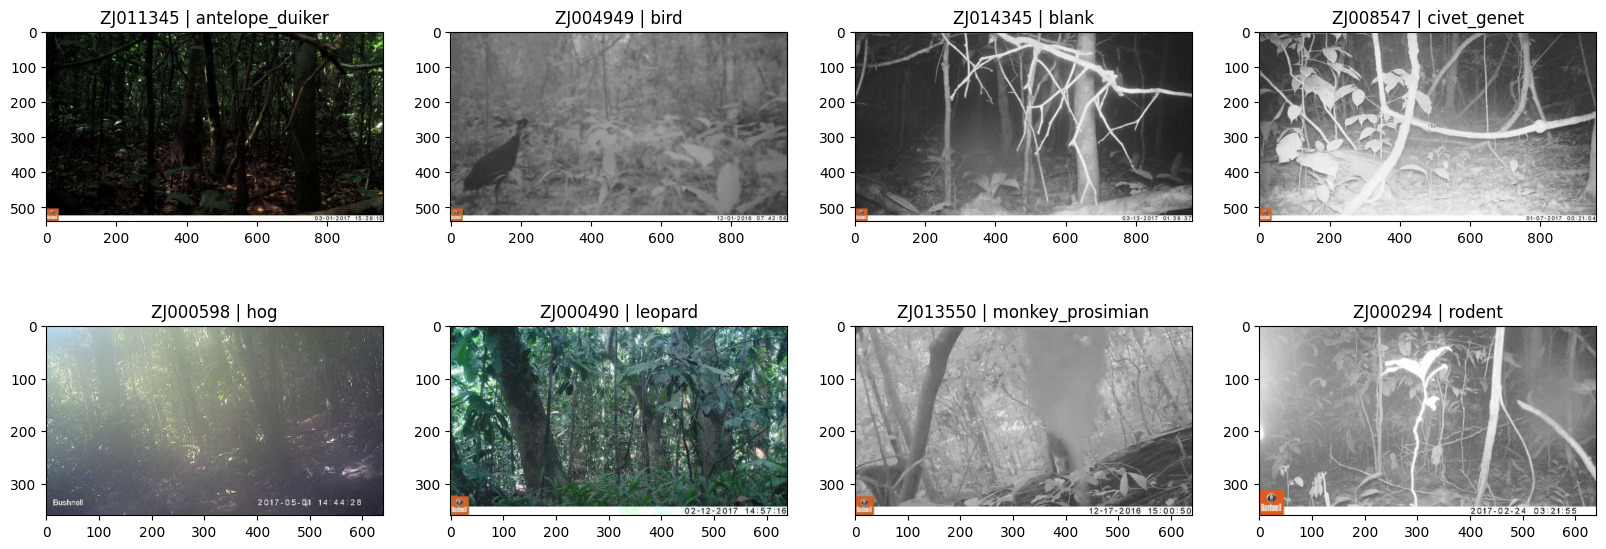

In [8]:
random_state = 11

# we'll create a grid with 8 positions, one for each label (7 species, plus blanks)
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 7))

# iterate through each species
for species, ax in zip(species_labels, axes.flat):
    # get an image ID for this species
    img_id = (
        train_labels[train_labels.loc[:,species] == 1]
        .sample(1, random_state=random_state)
        .index[0]
    )
    ax.imshow(Image.open('data/' + train_features.loc[img_id].filepath))
    ax.set_title(f"{img_id} | {species}")

Let's look at the distribution of species across the training set, first in terms of overall counts and then in percentage terms.

In [9]:
train_labels.sum().sort_values(ascending=False)

monkey_prosimian    2492.0
antelope_duiker     2474.0
civet_genet         2423.0
leopard             2254.0
blank               2213.0
rodent              2013.0
bird                1641.0
hog                  978.0
dtype: float64

In [10]:
train_labels.sum().divide(train_labels.shape[0]).sort_values(ascending=False)

monkey_prosimian    0.151140
antelope_duiker     0.150049
civet_genet         0.146955
leopard             0.136705
blank               0.134219
rodent              0.122089
bird                0.099527
hog                 0.059316
dtype: float64

In case you're curious, this distribution is not exactly what we find in the wild. The competition dataset has been curated a little bit to produce a more uniform distribution than we would see in the actual data.

There's a lot more data exploration to do. For example, you might also want to look at the distribution of image dimensions or camera trap sites. But since our primary goal here is to develop a benchmark, let's move on to the modeling!

In [11]:
train_features['resolution'] = train_features['filepath'].apply(lambda filename: lib.get_resolution('data/' + filename))

train_features['site_plus_resolution'] = train_features['site'] + '_' + train_features['resolution']

train_features

,filepath,site,resolution,site_plus_resolution
id,,,,
ZJ000000,train_features/ZJ000000.jpg,S0120,960x540,S0120_960x540
ZJ000001,train_features/ZJ000001.jpg,S0069,960x540,S0069_960x540
ZJ000002,train_features/ZJ000002.jpg,S0009,640x360,S0009_640x360
ZJ000003,train_features/ZJ000003.jpg,S0008,640x360,S0008_640x360
ZJ000004,train_features/ZJ000004.jpg,S0036,640x335,S0036_640x335
...,...,...,...,...
ZJ016483,train_features/ZJ016483.jpg,S0093,960x540,S0093_960x540
ZJ016484,train_features/ZJ016484.jpg,S0043,640x360,S0043_640x360
ZJ016485,train_features/ZJ016485.jpg,S0089,640x360,S0089_640x360


In [12]:
resolutions = train_features.groupby(['resolution']).agg(count=('resolution', 'count')).sort_values(by='count', ascending=False)

resolutions

,count
resolution,
640x360,7490
960x540,6345
640x335,970
360x240,864
960x515,458
160x120,293
360x215,67
160x95,1


In [13]:
sites = train_features.groupby(['site']).agg(count=('site', 'count')).sort_values(by='count', ascending=False)

sites

,count
site,
S0060,1132
S0009,664
S0063,557
S0008,541
S0036,456
...,...
S0092,3
S0078,2
S0079,2


In [14]:
resolutions_by_sites = train_features.groupby(['site', 'resolution']).agg(count=('site', 'count'))

resolutions_by_sites# .drop(columns='count')

count
site  resolution       
S0001 640x360        85
S0002 640x360       171
S0003 640x335         3
      640x360        55
S0004 640x360       109
...                 ...
S0192 640x360         6
S0193 360x240        38
S0196 360x240        15
S0197 640x360        17
S0198 360x240        23

[217 rows x 1 columns]

In [15]:
# # train_features['site'] = train_features['site'].str.strip().str.upper()
# # test_features['site'] = test_features['site'].str.strip().str.upper()

sites_train = train_features[['site']].drop_duplicates()
sites_test = test_features[['site']].drop_duplicates()

# sites_test.merge(sites_train, left_on='site', right_on='site', how='left', indicator=True)
#

train_sites = set(train_features['site'])
test_sites  = set(test_features['site'])

print(len(train_sites & test_sites))          # сколько общих
test_only = sorted(list(test_sites - train_sites))  # примеры, что есть в test, но нет в train

print(len(test_only))



0
51


### Mark over-exposed photos as such

In [16]:
# def to_tensor(filename):
#     return lib.to_rgb(torchvision.io.read_image(filename))
#
# def is_overexposed(row):
#     tensor = lib.to_rgb(torchvision.io.read_image('data/' + row['filepath']))
#     return lib.is_overexposed_torchvision(tensor.to('cuda'))
#
# # train_features['tensor'] = train_features['filepath'].apply(lambda filename: to_tensor('data/' + filename))


In [17]:
# train_features['is_overexposed_full'] = train_features.apply(is_overexposed, axis=1)
# train_features['is_overexposed'] = train_features['is_overexposed_full'].str[0]
#
# train_features

In [18]:
# %autoreload 2
# # ZJ015089 = train_all.loc['ZJ015089']
# # ZJ015089 = train_all.loc['ZJ000007']
# # ZJ015089 = train_all.loc['ZJ004820']
# over_exposed_photo = train_all.loc['ZJ008741']
#
# tensor = torchvision.io.read_image('data/' + over_exposed_photo['filepath'])
# if tensor.shape[0] == 1:
#     tensor = tensor.repeat(3, 1, 1)
# dec, f = lib.is_overexposed_torchvision(tensor.to('cuda'))
#
# dec, f

In [19]:
# from torchvision.transforms.functional import to_pil_image
#
# to_pil_image(torchvision.io.read_image('data/' + over_exposed_photo['filepath']))

In [20]:
train_all = train_features.merge(train_labels, on='id')
train_all

,filepath,site,resolution,site_plus_resolution,antelope_duiker,bird,blank,civet_genet,hog,leopard,monkey_prosimian,rodent
id,,,,,,,,,,,,
ZJ000000,train_features/ZJ000000.jpg,S0120,960x540,S0120_960x540,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
ZJ000001,train_features/ZJ000001.jpg,S0069,960x540,S0069_960x540,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
ZJ000002,train_features/ZJ000002.jpg,S0009,640x360,S0009_640x360,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
ZJ000003,train_features/ZJ000003.jpg,S0008,640x360,S0008_640x360,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
ZJ000004,train_features/ZJ000004.jpg,S0036,640x335,S0036_640x335,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
ZJ016483,train_features/ZJ016483.jpg,S0093,960x540,S0093_960x540,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
ZJ016484,train_features/ZJ016484.jpg,S0043,640x360,S0043_640x360,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
ZJ016485,train_features/ZJ016485.jpg,S0089,640x360,S0089_640x360,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [21]:
train_all[train_all['blank'] == 1].groupby(['site', 'resolution']).agg(count=('filepath', 'count'))

count
site  resolution       
S0001 640x360         6
S0002 640x360        36
S0003 640x335         3
      640x360        12
S0004 640x360         4
...                 ...
S0192 640x360         1
S0193 360x240        14
S0196 360x240         7
S0197 640x360         4
S0198 360x240         8

[177 rows x 1 columns]

In [22]:
# %autoreload 2
# import lib
# from torchvision.transforms.functional import to_pil_image
#
# # blanks = train_all[(train_all['blank'] == 1) & (train_all['site'] == 'S0002') & (train_all['resolution'] == '640x360')]
# blanks = train_all[(train_all['resolution'] == '640x360')]
#
# blanks = blanks.sample(n=15, random_state=1)
#
# blanks = blanks[blanks['is_overexposed'] != True]
#
# blanks = blanks.copy()
#
# # blanks = train_all.loc[['ZJ008001', 'ZJ011856', 'ZJ015487']]
#
# blanks['tensor'] = blanks['filepath'].apply(lambda filename: to_tensor('data/' + filename))
#
# blanks_ = torch.stack(list(blanks['tensor']), dim=0).to(torch.float32) / 255.0
#
# bg_template = lib.background_template(blanks_)
#
# to_pil_image(bg_template)

In [23]:
# # rand = train_all[train_all['resolution'] == '160x120'].iloc[10]['tensor'].to(torch.float32)
# rand = blanks_[0]
# to_pil_image(rand)

In [24]:
# alpha, beta = lib.affine_params_to_background(rand, bg_template)
# x_aligned = (alpha[:, None, None] * rand + beta[:, None, None]).clamp(0, 1.0)
#
# to_pil_image(x_aligned)
#
# # alpha, beta

In [25]:
# from itertools import zip_longest
# import math
#
# # we'll create a grid with 8 positions, one for each label (7 species, plus blanks)
# fig, axes = plt.subplots(nrows=math.ceil(len(blanks) / 3), ncols=3, figsize=(15, 45))
#
# for img_tensor, ax in zip_longest(blanks_, axes.flatten()):
#     if img_tensor is None:
#         if ax is not None:
#             ax.remove()
#         continue
#     if ax is None:
#         break
#
#     alpha, beta = lib.affine_params_to_background(img_tensor, bg_template)
#     x_aligned = (alpha[:, None, None] * img_tensor + beta[:, None, None]).clamp(0, 1.0)
#
#     ax.imshow(to_pil_image(x_aligned))
#
#     m_val = (img_tensor - bg_template).abs().sum(dim=0) / 3
#
#     std = m_val.std(dim=(0, 1)).mean()
#
#     koef = torch.where(m_val > 4 * std, 1.0, 0).mean(dim=(0, 1))
#
#     ax.set_title(f"{koef}")

### Examine photos (put your condition)

In [26]:
# from itertools import zip_longest
#
# random_state = 411
#
# # rows = train_all[(train_all['blank'] == 1) & (train_all['site'] == 'S0159') & (train_all['resolution'] == '160x120')]
# # rows = train_all.loc[['ZJ008001', 'ZJ011856', 'ZJ015487']]
#
# rows = blanks
#
# # rows = train_features[train_features['is_overexposed'] == True]
#
# # rows = train_features[(train_features['is_overexposed_mu'] > 240)]
#
# # rows = rows.sample(min(axes.size, len(rows)), random_state=random_state)
#
# fig, axes = plt.subplots(nrows=math.ceil(len(rows) / 3), ncols=3, figsize=(15, 18 * 2))
#
#
# # iterate through each species
# print(f'Total rows: {len(rows)}')
#
# for img_tensor, ax in zip_longest(list(rows.iterrows()), axes.flatten()):
#     if img_tensor is None:
#         if ax is not None:
#             ax.remove()
#         continue
#     if ax is None:
#         break
#     img = Image.open('data/' + img_tensor[1]['filepath'])
#     ax.imshow(img)
#     ax.set_title(f"{img_tensor[1].name} {img_tensor[1]['resolution']}")

## Split into train and evaluation sets
First, we'll need to split the images into train and eval sets. We'll put aside 25% of the data for evaluation and stratify by the target labels to ensure we have similar relative frequencies of each class in the train and eval sets.

In [27]:
# from sklearn.model_selection import train_test_split

y = train_labels
x = train_features.loc[y.index]

# # note that we are casting the species labels to an indicator/dummy matrix
# x_train, x_eval, y_train, y_eval = train_test_split(
#     x, y, stratify=y, test_size=0.20
# )

In [28]:
val_sites = ['S0060','S0063','S0043','S0038','S0120','S0014']

mask_val  = x['site'].isin(val_sites)

x_train = x[ ~mask_val ]
y_train = y[ ~mask_val ]

x_eval = x[ mask_val ]
y_eval = y[ mask_val ]



Here's what `x_train` and `y_train` look like now:

In [29]:
x_train

,filepath,site,resolution,site_plus_resolution
id,,,,
ZJ000001,train_features/ZJ000001.jpg,S0069,960x540,S0069_960x540
ZJ000002,train_features/ZJ000002.jpg,S0009,640x360,S0009_640x360
ZJ000003,train_features/ZJ000003.jpg,S0008,640x360,S0008_640x360
ZJ000004,train_features/ZJ000004.jpg,S0036,640x335,S0036_640x335
ZJ000005,train_features/ZJ000005.jpg,S0019,960x540,S0019_960x540
...,...,...,...,...
ZJ016482,train_features/ZJ016482.jpg,S0146,640x360,S0146_640x360
ZJ016483,train_features/ZJ016483.jpg,S0093,960x540,S0093_960x540
ZJ016485,train_features/ZJ016485.jpg,S0089,640x360,S0089_640x360


In [30]:
y_train.head()

,antelope_duiker,bird,blank,civet_genet,hog,leopard,monkey_prosimian,rodent
id,,,,,,,,
ZJ000001,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
ZJ000002,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
ZJ000003,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
ZJ000004,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
ZJ000005,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [31]:
x_train.shape, y_train.shape, x_eval.shape, y_eval.shape

((13190, 4), (13190, 8), (3298, 4), (3298, 8))

Next, let's validate that our split has resulted in roughly similar relative distributions of species across the train and eval sets (because of how we passed `stratify=y` above).

In [32]:
split_pcts = pd.DataFrame(
    {
        "train": y_train.idxmax(axis=1).value_counts(normalize=True),
        "eval": y_eval.idxmax(axis=1).value_counts(normalize=True),
    }
)
print("Species percentages by split")
(split_pcts.fillna(0) * 100).astype(int)

Species percentages by split


,train,eval
antelope_duiker,15,14
bird,11,4
blank,15,4
civet_genet,10,29
hog,5,6
leopard,11,21
monkey_prosimian,17,6
rodent,12,11


## The Dataset

First, we'll create an `ImagesDataset` class that will define how we access our data and any transformations we might want to apply. 

This new class will inherit from the PyTorch [`Dataset`](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html) class, but we'll also need to define our own `__init__`, `__len__` and `__getitem__` **special methods**:
* **`__init__`** will instantiate the dataset object with two dataframes: an `x_train` df containing image IDs and image file paths, and a `y_train` df containing image IDs and labels. This will run once when we first create the dataset object, e.g. with `dataset = ImagesDataset(x_train, y_train)`.
* **`__getitem__`** will define how we access a sample from the data. This method gets called whenever we use an indexing operation like `dataset[index]`. In this case, whenever accessing a particular image sample (for example, to get the first image we'd do `dataset[0]`) the following will happen:
  * look up the image filepath using the index
  * load the image with [`PIL.Image`](https://pillow.readthedocs.io/en/stable/reference/Image.html)
  * apply some transformations (more on this below)
  * return a dictionary containing the image ID, the image itself as a Tensor, and a label (if it exists)
* **`__len__`** simply returns the size of the dataset, which we do by calling `len` on the input dataframe.

In [33]:
from torchvision.models import ResNet50_Weights

class ImagesDataset(Dataset):
    def __init__(self, x_df, y_df=None):
        self.data = x_df
        self.label = y_df
        # self.transform = ResNet50_Weights.IMAGENET1K_V2.transforms(interpolation = InterpolationMode.BILINEAR)

        self.transform = transforms.Compose(
            [
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)
                ),
            ]
        )

    def __getitem__(self, index):
        image = Image.open('data/' + self.data.iloc[index]["filepath"]).convert("RGB")
        image = self.transform(image)
        image_id = self.data.index[index]
        # if we don't have labels (e.g. for test set) just return the image and image id
        if self.label is None:
            sample = {"image_id": image_id, "image": image}
        else:
            label = torch.tensor(self.label.iloc[index].values, dtype=torch.float)
            sample = {"image_id": image_id, "image": image, "label": label}
        return sample

    def __len__(self):
        return len(self.data)

## Model instantiation (possibly from a checkpoint)

In [34]:
from torch import nn
import torchvision.models as models
from torchvision.models import ResNet50_Weights
import glob
import re

if False:
    files = glob.glob(f'./models/model_*.pth')

    pattern = re.compile(r"model_(\d+)\.pth$")

    epochs = [ pattern.search(file)[1] for file in files if pattern.search(file) != None ]

    if len(epochs) == 0:
        print('no models found')
        raise ValueError('No model found')

    epochs.sort(reverse=True)
    epoch = epochs[ 0 ]

    print(f'Loading model from epoch { epoch }')

    model = torch.load(f'./models/model_{ epoch }.pth', weights_only=False)
else:
    model = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
    # model = models.resnet50(pretrained=True)

    model.fc = nn.Sequential(
        nn.Linear(2048, 100),  # dense layer takes a 2048-dim input and outputs 100-dim
        nn.ReLU(inplace=True),  # ReLU activation introduces non-linearity
        nn.Dropout(0.1),  # common technique to mitigate overfitting
        nn.Linear(100, 8),  # final dense layer outputs 8-dim corresponding to our target classes
    )

    model.tracking_loss = []
    model.tracking_loss_val = []
    model.epoch = 0

tracking_loss = model.tracking_loss
tracking_loss_val = model.tracking_loss_val

## Loss function and optimizer
We'll use the cross entropy loss function to compute the loss for each training batch.
Cross entropy loss (or log loss) is a commonly used loss function for multi-class (not multi-label) image classification. We'll use this to compute loss for each training batch and then update our parameters accordingly. 

In [35]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

## Training

In [36]:
num_epochs = 5

from torch.utils.data import DataLoader

T = 3.5

batch_size = 128

train_dataset = ImagesDataset(x_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

eval_dataset = ImagesDataset(x_eval, y_eval)
eval_dataloader = DataLoader(eval_dataset, batch_size=batch_size)

model.to(torch.device("cuda"))
criterion.to(torch.device("cuda"))

for epoch in range(model.epoch, model.epoch + num_epochs):
    print(f"Starting epoch {epoch}")
    print(f"Training: ")

    model.train()

    loss_acc = 0

    # iterate through the dataloader batches. tqdm keeps track of progress.
    for batch_n, batch in tqdm(enumerate(train_dataloader), total=len(train_dataloader)):
        # 1) zero out the parameter gradients so that gradients from previous batches are not used in this step
        optimizer.zero_grad()

        # 2) run the forward step on this batch of images
        outputs = model(batch["image"].to(torch.device("cuda")))

        # 3) compute the loss
        loss = criterion(outputs, batch["label"].to(torch.device("cuda")))
        # let's keep track of the loss by epoch and batch
        # tracking_loss[(epoch, batch_n)] = loss.item()

        loss_acc += loss.item()

        # 4) compute our gradients
        loss.backward()
        # update our weights
        optimizer.step()

    tracking_loss.append(loss_acc / len(train_dataloader))

    print(f"Evaluation: ")

    model.eval()

    loss_acc = 0

    # iterate through the dataloader batches. tqdm keeps track of progress.
    for batch_n, batch in tqdm(enumerate(eval_dataloader), total=len(eval_dataloader)):
        # 2) run the forward step on this batch of images
        outputs = model(batch["image"].to(torch.device("cuda")))

        # 3) compute the loss
        loss = criterion(outputs, batch["label"].to(torch.device("cuda")))
        # let's keep track of the loss by epoch and batch
        # tracking_loss_val[(epoch, batch_n)] = loss.item()

        loss_acc += loss.item()

    tracking_loss_val.append(loss_acc / len(eval_dataloader))

    torch.save(model, f"./models/model_{str(epoch).rjust(2, "0")}.pth")

    model.epoch += 1

Starting epoch 0
Training: 


100%|██████████| 104/104 [00:30<00:00,  3.42it/s]


Evaluation: 


100%|██████████| 26/26 [00:08<00:00,  3.04it/s]


Starting epoch 1
Training: 


100%|██████████| 104/104 [00:29<00:00,  3.47it/s]


Evaluation: 


100%|██████████| 26/26 [00:08<00:00,  3.04it/s]


Starting epoch 2
Training: 


100%|██████████| 104/104 [00:29<00:00,  3.48it/s]


Evaluation: 


100%|██████████| 26/26 [00:08<00:00,  2.90it/s]


Starting epoch 3
Training: 


100%|██████████| 104/104 [00:30<00:00,  3.44it/s]


Evaluation: 


100%|██████████| 26/26 [00:08<00:00,  3.06it/s]


Starting epoch 4
Training: 


100%|██████████| 104/104 [00:30<00:00,  3.46it/s]


Evaluation: 


100%|██████████| 26/26 [00:08<00:00,  3.03it/s]


## Validating

In [37]:
tracking_loss, tracking_loss_val

([1.9157370741550739,
  1.5901054006356459,
  1.326613527077895,
  1.0944337873504713,
  0.9107510292759309],
 [1.689360838669997,
  1.489197877737192,
  1.4385844239821801,
  1.3855506410965552,
  1.4350881989185627])

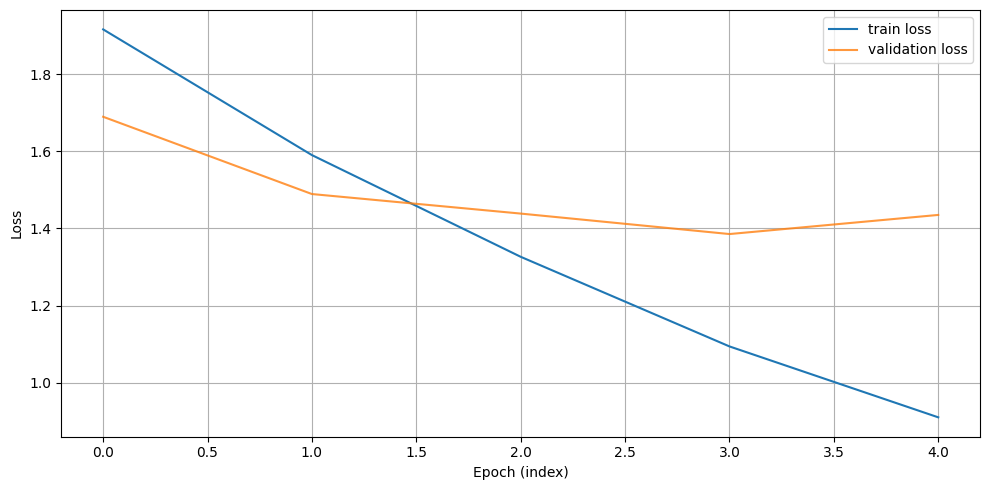

In [38]:
fig, ax = plt.subplots(figsize=(10, 5))
epochs_train = list(range(len(tracking_loss)))
epochs_val = list(range(len(tracking_loss_val)))
ax.plot(epochs_train, tracking_loss, label="train loss")
ax.plot(epochs_val, tracking_loss_val, label="validation loss", alpha=0.8)
ax.set_xlabel("Epoch (index)")
ax.set_ylabel("Loss")
ax.legend(loc="best")
ax.grid(True)
fig.tight_layout()


## Evaluation
So far, not so bad. We've shown an improvement in the loss on the training set, but that tells us little about how our model will do on new data. Let's reload our saved model and try generating some predictions on the evaluation split we created earlier.

In [39]:
eval_dataset = ImagesDataset(x_eval, y_eval)
eval_dataloader = DataLoader(eval_dataset, batch_size=batch_size)

### Make predictions
We'll iterate through the eval dataloader in batches, just like we did for training, but this time we aren't going to need to compute gradients or update weights. For each batch, we'll do the following:
1. Run the forward pass to get the model output or logits
2. Apply a softmax function to convert the logits into probability space with range[0,1]. During training, the softmax operation was handled internally by `nn.CrossEntropyLoss`. We aren't computing the loss now because we are just doing evaluation, but we still want the predictions to be in the range[0,1]. 
3. Store the results in a dataframe for further analysis

In [40]:
preds_collector = []

# put the model in eval mode so we don't update any parameters
model.eval()

model.to(torch.device("cuda"))

# we aren't updating our weights so no need to calculate gradients
with torch.no_grad():
    for batch in tqdm(eval_dataloader, total=len(eval_dataloader)):
        # 1) run the forward step
        logits = model.forward(batch["image"].to(torch.device("cuda")))
        # 2) apply softmax so that model outputs are in range [0,1]
        preds = nn.functional.softmax(logits / T, dim=1)
        # 3) store this batch's predictions in df
        # note that PyTorch Tensors need to first be detached from their computational graph before converting to numpy arrays
        preds_df = pd.DataFrame(
            preds.detach().to('cpu').numpy(),
            index=batch["image_id"],
            columns=species_labels,
        )
        preds_collector.append(preds_df)

eval_preds_df = pd.concat(preds_collector)
eval_preds_df

100%|██████████| 26/26 [00:08<00:00,  3.09it/s]


,antelope_duiker,bird,blank,civet_genet,hog,leopard,monkey_prosimian,rodent
ZJ000000,0.202571,0.142456,0.181946,0.070164,0.118041,0.086628,0.129554,0.068640
ZJ000006,0.104055,0.068382,0.128203,0.196786,0.115059,0.106710,0.094477,0.186327
ZJ000011,0.137788,0.108558,0.139525,0.083114,0.143023,0.124453,0.132668,0.130871
ZJ000023,0.103275,0.083652,0.137847,0.084152,0.191885,0.205940,0.083737,0.109512
ZJ000024,0.164539,0.092604,0.141679,0.075118,0.100196,0.129272,0.205210,0.091382
...,...,...,...,...,...,...,...,...
ZJ016461,0.224648,0.140116,0.135305,0.062012,0.113734,0.066367,0.150777,0.107041
ZJ016462,0.129784,0.106362,0.141206,0.082120,0.138566,0.143026,0.135503,0.123433
ZJ016473,0.098916,0.078080,0.142114,0.225690,0.092344,0.081338,0.075879,0.205639
ZJ016475,0.064693,0.115886,0.167351,0.076314,0.115508,0.272856,0.086594,0.100798


### Predicted labels distribution
First let's review the species distribution we saw in the training set.

In [41]:
print("True labels (training):")
y_train.idxmax(axis=1).value_counts()

True labels (training):


monkey_prosimian    2273
blank               2078
antelope_duiker     1999
rodent              1632
leopard             1536
bird                1485
civet_genet         1436
hog                  751
Name: count, dtype: int64

Here's the distribution of our predictions on the eval set. 

In [42]:
print("Predicted labels (eval):")
eval_preds_df.idxmax(axis=1).value_counts()

Predicted labels (eval):


civet_genet         890
antelope_duiker     637
blank               476
leopard             368
rodent              331
monkey_prosimian    250
hog                 184
bird                162
Name: count, dtype: int64

The actual evaluation set is more evenly distributed than our predictions, so we already know there is some room for improvement here.

In [43]:
print("True labels (eval):")
y_eval.idxmax(axis=1).value_counts()

True labels (eval):


civet_genet         987
leopard             718
antelope_duiker     475
rodent              381
hog                 227
monkey_prosimian    219
bird                156
blank               135
Name: count, dtype: int64

### Accuracy
Now let's compute how accurate our model is and compare that against some trivial baseline models. First let's get the labels with the highest score for each image.

In [44]:
eval_predictions = eval_preds_df.idxmax(axis=1)
eval_predictions.head()

ZJ000000     antelope_duiker
ZJ000006         civet_genet
ZJ000011                 hog
ZJ000023             leopard
ZJ000024    monkey_prosimian
dtype: object

Random guessing across 8 classes would yield an accuracy of 12.5% (1/8). But we could construct a slightly better trivial model by always guessing the most common class ("monkey_prosimian" images in this case).

If we were to always guess that an image is `monkey_prosimian`, we could achieve accuracy of 15.8%.

In [45]:
eval_true = y_eval.idxmax(axis=1)

(eval_true == "monkey_prosimian").sum() / len(eval_predictions)

np.float64(0.0664038811400849)

Let's see how our model compares. We take the species with the highest score for each image (`eval_predictions`) and compare that to the true labels.

In [46]:
correct = (eval_predictions == eval_true).sum()
accuracy = correct / len(eval_predictions)
accuracy.item()

0.553668890236507

Let's look at the predictions from another angle. 

We can see from the confusion matrix below that our model does reasonably well on some species, but we have plenty of room for improvement on antelopes, birds, hogs and blanks.

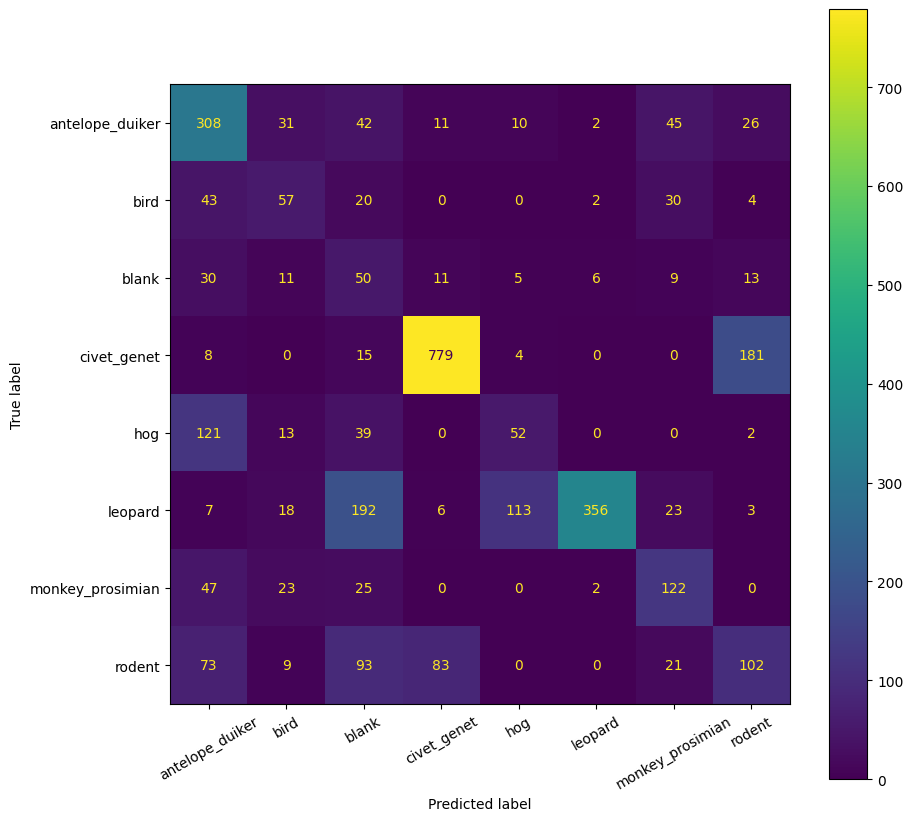

In [47]:
from sklearn.metrics import ConfusionMatrixDisplay

fig, ax = plt.subplots(figsize=(10, 10))
cm = ConfusionMatrixDisplay.from_predictions(
    y_eval.idxmax(axis=1),
    eval_preds_df.idxmax(axis=1),
    ax=ax,
    xticks_rotation=30,
    colorbar=True,
)

That's where you come in! What can you do to improve on this benchmark?

Here are some ideas you might want to try:
* Train on the full training dataset. We've only used 50% of the training data so far.
* Train for more epochs. We've only done 1 so far.
* Try another pretrained model. For example, you may have more success with EfficientNet, or another ResNet model with more layers like ResNet152. See what's available from pytorch [here](https://pytorch.org/vision/stable/models.html). You may also want to review which models are or have been state of the art for image classification tasks, for example on [paperswithcode.com](https://paperswithcode.com/task/image-classification). Keep in mind that different models will require different input and output dimensions, so you'll need to update how you construct `model` above.
* Experiment with different loss functions.
* Experiment with different learning rates or learning rate schedulers.
* Add more layers to the model head (`model.fc`).
* You also may want to consider freezing the weights in the backbone model and only training the head (`model.fc`). If this results in higher accuracy, that suggests the current approach may be overwriting the backbone weights in a problematic way. One approach here would be to train just the model head, and then unfreeze the backbone but train at a lower learning rate.
* Training will be much faster using GPUs, but you will need to make some small tweaks to the code.
* As you become more comfortable iterating through different versions of the model, you may want to try out [PyTorch Lightning](https://www.pytorchlightning.ai/) or [Lightning Flash](https://lightning-flash.readthedocs.io/en/latest/quickstart.html), which build upon PyTorch and eliminate a lot of boilerplate code, in addition to providing a more complete research framework for deep learning problems.

## Create submission

In [48]:
test_dataset = ImagesDataset(test_features.filepath.to_frame())
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

In [49]:
preds_collector = []

# put the model in eval mode so we don't update any parameters
model.eval()

# we aren't updating our weights so no need to calculate gradients
with torch.no_grad():
    for batch in tqdm(test_dataloader, total=len(test_dataloader)):
        # run the forward step
        logits = model.forward(batch["image"].to(torch.device("cuda")))
        # apply softmax so that model outputs are in range [0,1]
        preds = nn.functional.softmax(logits / T, dim=1)
        # store this batch's predictions in df
        # note that PyTorch Tensors need to first be detached from their computational graph before converting to numpy arrays
        preds_df = pd.DataFrame(
            preds.detach().to('cpu').numpy(),
            index=batch["image_id"],
            columns=species_labels,
        )

        preds_collector.append(preds_df)

submission_df = pd.concat(preds_collector)
submission_df

100%|██████████| 35/35 [00:09<00:00,  3.58it/s]


,antelope_duiker,bird,blank,civet_genet,hog,leopard,monkey_prosimian,rodent
ZJ016488,0.167431,0.087915,0.163012,0.178800,0.078326,0.076961,0.085266,0.162289
ZJ016489,0.251286,0.094188,0.120087,0.064045,0.144715,0.073046,0.163884,0.088748
ZJ016490,0.255776,0.097512,0.134698,0.088878,0.159064,0.079348,0.098580,0.086144
ZJ016491,0.076254,0.070757,0.105327,0.083642,0.127778,0.366183,0.079428,0.090632
ZJ016492,0.176960,0.165241,0.123789,0.076572,0.097315,0.079450,0.161449,0.119224
...,...,...,...,...,...,...,...,...
ZJ020947,0.139057,0.184921,0.148880,0.069639,0.142634,0.102478,0.115998,0.096393
ZJ020948,0.157370,0.136613,0.145293,0.078637,0.120970,0.150557,0.114949,0.095612
ZJ020949,0.152862,0.070990,0.131594,0.241065,0.090065,0.063862,0.065176,0.184387
ZJ020950,0.153521,0.112571,0.138881,0.071897,0.102424,0.105819,0.217832,0.097055


In [50]:
submission_format = pd.read_csv("data/submission_format.csv", index_col="id")

assert all(submission_df.index == submission_format.index)
assert all(submission_df.columns == submission_format.columns)

In [51]:
submission_df.to_csv("submission.csv")